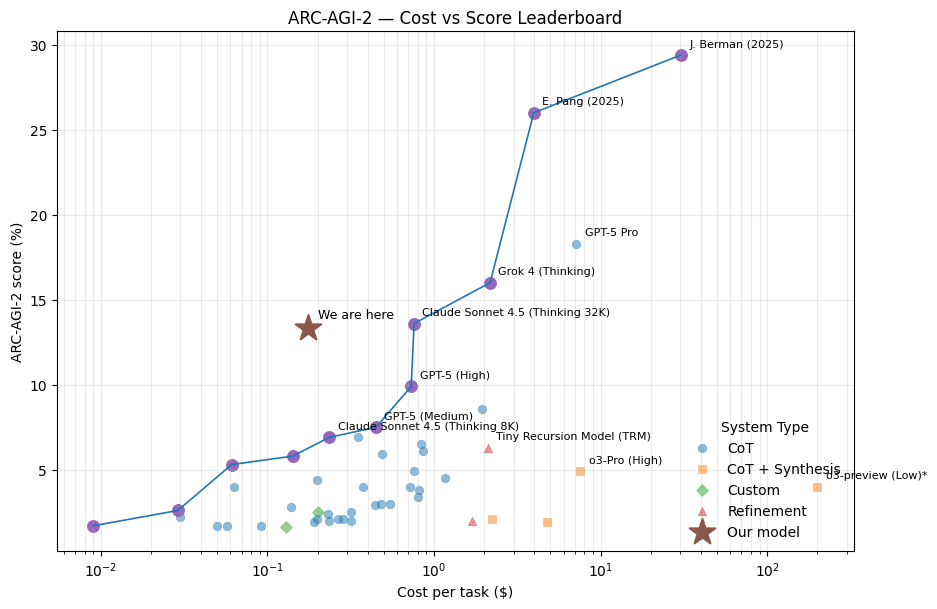

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
os.chdir("/home/feline/llms_ftw/src")

# 1) Load the data (from the CSV above)
df = pd.read_csv("arc_agi_leaderboard.csv")
# Parse to numerics
def _pct(x):
    try: return float(str(x).replace("%",""))
    except: return None
def _usd(x):
    try: return float(str(x).replace("$",""))
    except: return None
df["ARC_AGI_2"] = df["ARC-AGI-2"].map(_pct)
df["Cost"]      = df["Cost/Task"].map(_usd)

# ----------- FILTERS (edit to taste) -----------
min_score = 1.5       # hide tiny-scoring clutter
min_cost, max_cost = 0.005, 300
hide_types = {"Base LLM"}   # show CoT / Refinement / Custom / CoT+Synthesis

clean = (
    df.dropna(subset=["ARC_AGI_2","Cost"])
      .query("(@min_score <= ARC_AGI_2) and (@min_cost <= Cost <= @max_cost)")
)
clean = clean[~clean["System Type"].isin(hide_types)]

# ----------- Pareto frontier (min cost, max score) -----------
clean = clean.sort_values(["Cost","ARC_AGI_2"])
best = -np.inf
pareto_mask = []
for _, r in clean.iterrows():
    if r["ARC_AGI_2"] > best:
        pareto_mask.append(True); best = r["ARC_AGI_2"]
    else:
        pareto_mask.append(False)
clean["Pareto"] = pareto_mask
pareto = clean[clean["Pareto"]]

# ----------- Plot -----------
fig, ax = plt.subplots(figsize=(9.5,6.2))

marker_map = {
    "CoT": "o",
    "CoT + Synthesis": "s",
    "Refinement": "^",
    "Custom": "D",
}
# faint background points
for stype, g in clean.groupby("System Type"):
    ax.scatter(g["Cost"], g["ARC_AGI_2"],
               label=stype,
               marker=marker_map.get(stype, "o"),
               s=38, linewidths=0.4, alpha=0.5)

# emphasize Pareto points and connect them
ax.scatter(pareto["Cost"], pareto["ARC_AGI_2"], marker="o", s=70, linewidths=0.9, alpha=1.0)
ax.plot(pareto["Cost"], pareto["ARC_AGI_2"], linewidth=1.2)

ax.set_xscale("log")
ax.set_xlabel("Cost per task ($)")
ax.set_ylabel("ARC-AGI-2 score (%)")
ax.set_title("ARC-AGI-2 — Cost vs Score Leaderboard")
ax.grid(True, which="both", alpha=0.25)
#ax.legend(title="System Type", frameon=False, loc="lower right")

# ----------- Label some “big” frontier systems -----------
label_candidates = {
    "J. Berman (2025)",
    "E. Pang (2025)",
    "GPT-5 Pro",
    "Grok 4 (Thinking)",
    "Claude Sonnet 4.5 (Thinking 32K)",
    "GPT-5 (High)",
    "GPT-5 (Medium)",
    "o3-Pro (High)",
    "o3-preview (Low)*",
    "Tiny Recursion Model (TRM)",
}

def _annotate_row(row, dx=6, dy=6, f=8):
    ax.annotate(row["AI System"], (row["Cost"], row["ARC_AGI_2"]),
                xytext=(dx, dy), textcoords="offset points", fontsize=f)

# label Pareto points with decent scores and special callouts
for _, r in pareto.iterrows():
    if (r["AI System"] in label_candidates) or (r["ARC_AGI_2"] >= 6):
        _annotate_row(r)

# also label any explicit candidates that aren’t on Pareto
for _, r in clean.iterrows():
    if r["AI System"] in label_candidates and not r["Pareto"]:
        _annotate_row(r)

# ----------- Add your standout point -----------
def add_custom_point(name, arc2_percent, cost_dollars, legend_name=None):
    legend_label = legend_name if legend_name is not None else name
    ax.scatter([cost_dollars], [arc2_percent],
               marker="*", s=380, linewidths=1.4, label=legend_label, zorder=5)
    ax.annotate(name, (cost_dollars, arc2_percent),
                xytext=(7,7), textcoords="offset points", fontsize=9)

# Example (annotation vs. legend name):
add_custom_point("We are here", 13.33, 0.175, legend_name="Our model")

# ---- rebuild legend after plotting everything ----
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # dedupe
ax.legend(by_label.values(), by_label.keys(),
          title="System Type", frameon=False, loc="lower right")

plt.tight_layout()
plt.savefig("arc_agi_2.svg", format="svg", bbox_inches="tight")
plt.show()


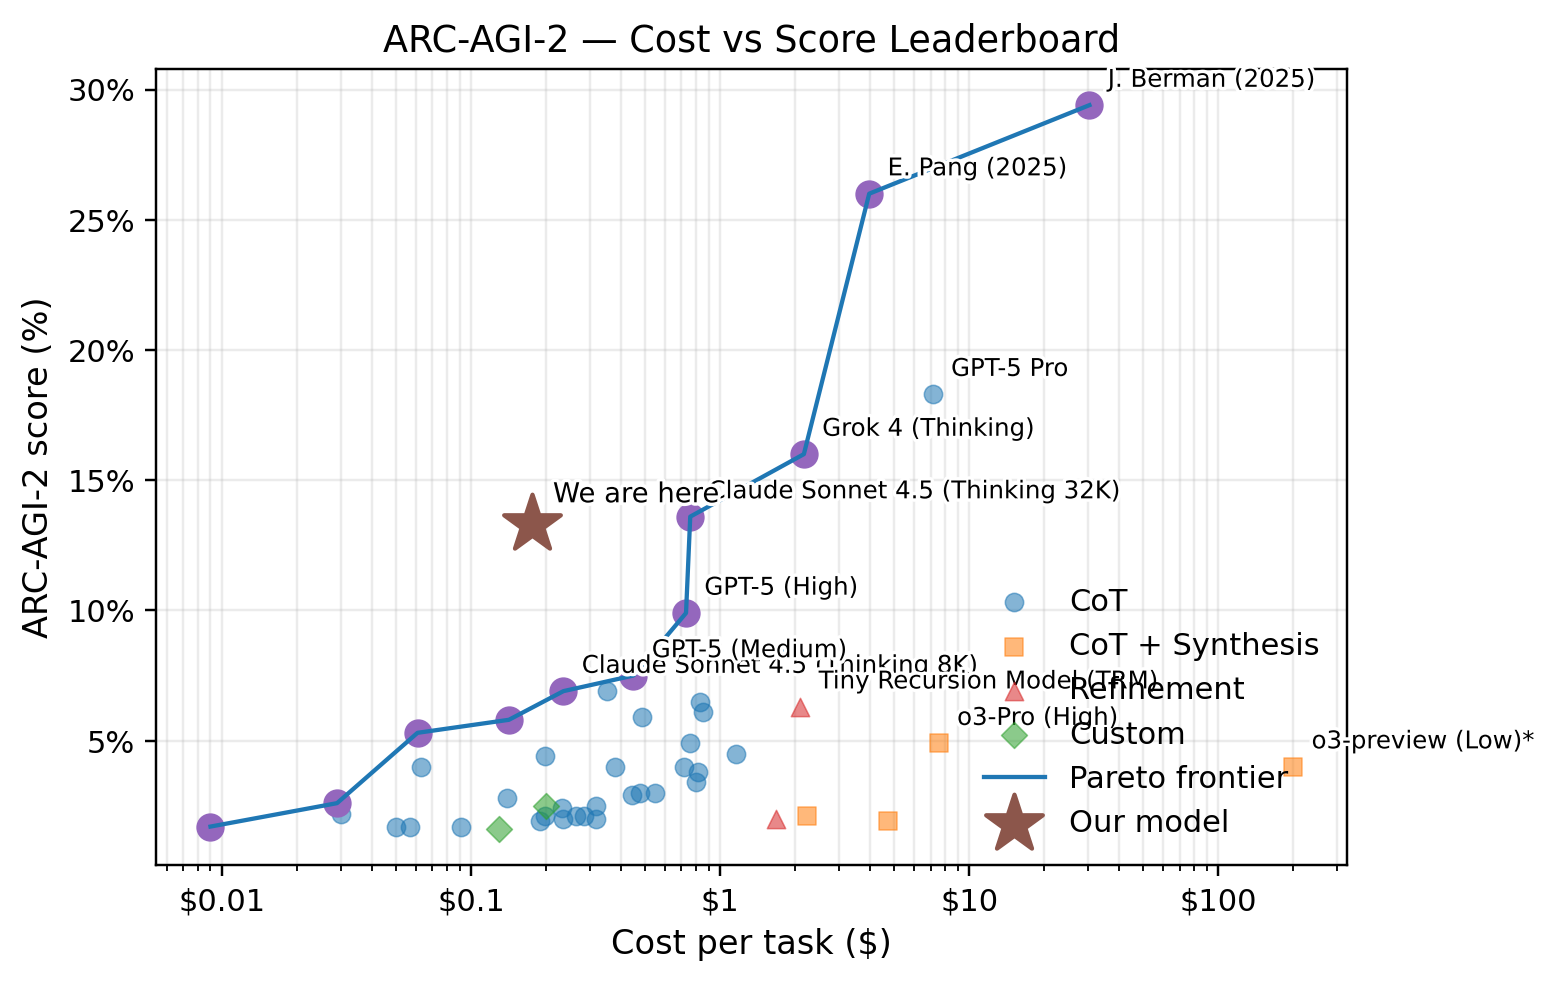

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import numpy as np
import os

os.chdir("/home/feline/llms_ftw/src")

# ---------------- Typographic defaults (journal-ish) ----------------
plt.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 9,
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# ---------------- Load & parse ----------------
df = pd.read_csv("arc_agi_leaderboard.csv")

def _pct(x):
    try: return float(str(x).replace("%",""))
    except: return None

def _usd(x):
    try: return float(str(x).replace("$",""))
    except: return None

df["ARC_AGI_2"] = df["ARC-AGI-2"].map(_pct)
df["Cost"]      = df["Cost/Task"].map(_usd)

# ---------------- Filters ----------------
min_score = 1.5
min_cost, max_cost = 0.005, 300
hide_types = {"Base LLM"}

clean = (
    df.dropna(subset=["ARC_AGI_2","Cost"])
      .query("(@min_score <= ARC_AGI_2) and (@min_cost <= Cost <= @max_cost)")  # <-- fixed @
)
clean = clean[~clean["System Type"].isin(hide_types)].copy()

# ---------------- Pareto frontier (min cost, max score) ----------------
clean = clean.sort_values(["Cost","ARC_AGI_2"])
best = -np.inf
pareto_mask = []
for _, r in clean.iterrows():
    if r["ARC_AGI_2"] > best:
        pareto_mask.append(True); best = r["ARC_AGI_2"]
    else:
        pareto_mask.append(False)
clean["Pareto"] = pareto_mask
pareto = clean[clean["Pareto"]].copy()

# ---------------- Plot ----------------
# For most journals, ~3.5" or ~7.2" width fits single/double column. Adjust if needed.
fig, ax = plt.subplots(figsize=(7.2, 4.6))

marker_map = {
    "CoT": "o",
    "CoT + Synthesis": "s",
    "Refinement": "^",
    "Custom": "D",
}

# faint background points
for stype, g in clean.groupby("System Type"):
    ax.scatter(
        g["Cost"], g["ARC_AGI_2"],
        label=stype,
        marker=marker_map.get(stype, "o"),
        s=36, linewidths=0.5, alpha=0.55
    )

# emphasize Pareto points and connect them
ax.scatter(
    pareto["Cost"], pareto["ARC_AGI_2"],
    marker="o", s=70, linewidths=0.9, alpha=1.0
)
pareto_line, = ax.plot(
    pareto["Cost"], pareto["ARC_AGI_2"], linewidth=1.4
)

ax.set_xscale("log")
ax.set_xlabel("Cost per task ($)")
ax.set_ylabel("ARC-AGI-2 score (%)")
ax.set_title("ARC-AGI-2 — Cost vs Score Leaderboard")

# Subtle grid, behind data
ax.grid(True, which="both", alpha=0.25)
ax.set_axisbelow(True)

# Log tick locator + currency on x
ax.xaxis.set_major_locator(mtick.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(mtick.LogLocator(base=10.0, subs=range(2,10)))
ax.xaxis.set_minor_formatter(mtick.NullFormatter())
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda v, pos: f"${v:g}"))

# Percent on y
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.0f%%"))

# ---------------- Labels for key points ----------------
label_candidates = {
    "J. Berman (2025)",
    "E. Pang (2025)",
    "GPT-5 Pro",
    "Grok 4 (Thinking)",
    "Claude Sonnet 4.5 (Thinking 32K)",
    "GPT-5 (High)",
    "GPT-5 (Medium)",
    "o3-Pro (High)",
    "o3-preview (Low)*",
    "Tiny Recursion Model (TRM)",
}

def _annotate_row(row, dx=6, dy=6, f=8):
    txt = ax.annotate(
        row["AI System"], (row["Cost"], row["ARC_AGI_2"]),
        xytext=(dx, dy), textcoords="offset points", fontsize=f
    )
    # thin white halo for legibility over points/line
    txt.set_path_effects([pe.withStroke(linewidth=2.25, foreground="white")])

for _, r in pareto.iterrows():
    if (r["AI System"] in label_candidates) or (r["ARC_AGI_2"] >= 6):
        _annotate_row(r)

for _, r in clean.iterrows():
    if r["AI System"] in label_candidates and not r["Pareto"]:
        _annotate_row(r)

# ---------------- Your standout point (star + custom legend label) ----------------
def add_custom_point(name, arc2_percent, cost_dollars, legend_name=None):
    legend_label = legend_name if legend_name is not None else name
    star = ax.scatter(
        [cost_dollars], [arc2_percent],
        marker="*", s=380, linewidths=1.4, label=legend_label, zorder=6
    )
    txt = ax.annotate(
        name, (cost_dollars, arc2_percent),
        xytext=(7,7), textcoords="offset points", fontsize=9
    )
    txt.set_path_effects([pe.withStroke(linewidth=2.25, foreground="white")])
    return star

star_artist = add_custom_point("We are here", 13.33, 0.175, legend_name="Our model")

# ---------------- Legends: types + special entries ----------------
# 1) Legend for system types (dedup)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# 2) Add proxy for Pareto frontier line (clear label in legend)
pareto_proxy = Line2D([0],[0], linestyle="-", linewidth=1.4)
by_label["Pareto frontier"] = pareto_proxy
by_label["Our model"] = star_artist  # ensure preferred order label

# Build legend with clean ordering (system types first, then specials)
order = [k for k in marker_map.keys() if k in by_label] + ["Pareto frontier", "Our model"]
ordered = [(k, by_label[k]) for k in order if k in by_label]

leg = ax.legend(
    [h for k,h in ordered],
    [k for k,h in ordered],
    title="",
    frameon=False, loc="lower right"
)

# ---------------- Save vector + metadata ----------------
plt.tight_layout()
plt.savefig(
    "arc_agi_2.pdf", format="pdf", bbox_inches="tight",
    metadata={"Title": "ARC-AGI-2 — Cost vs Score Leaderboard"}
)
plt.savefig("arc_agi_2.svg", format="svg", bbox_inches="tight")
plt.show()
